In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchsummary import summary
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import torch
torch.manual_seed(0)
import random
random.seed(0)

## Explanation

### Preprocessing

Since the VIS-NIR images were so large that they couldn't be held in memory for training deep learning models, the images were split into 25x25 patches. Then PCA was performed on these patches to reduce the spectral dimension from 673 to 32 principal components.

I tested splitting the mites into different infestation levels, according to level 1: 1-15 motiles, level 2:15-70 motiles, level 3: 70+ motiles. This did not work well, with lots of confusion between infestation levels, so I pooled the mite groups together into one mite group, so there are three classes: control, mites, drought. Then the images are classified for each imaging day seperately.


### Model

A ResNet18 model, modified to take as input the PCA dim. red image patches instead of RGB images.

The model is trained on the patches, and the loss function takes into account how well it does on the patches. But in addition there is an image_wise classification where the voting for all the patches for each image is used to create one overall classification for the


### Results



In [4]:
class PrecomputedPatchDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.patches = data["patches"]    # (N, C, ph, pw) where C=B or K
        self.labels  = data["labels"]    # (N,)
        # Backward compatible: if image_ids missing, make a dummy sequence
        self.image_ids = data["image_ids"] if "image_ids" in data else np.arange(len(self.labels), dtype=np.int32)


    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.patches[idx]).float()   # (C, ph, pw)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        img_id = int(self.image_ids[idx])
        return x, y, img_id


In [5]:
# Using the dataset from imaging day 9 here
full_train_dataset9 = PrecomputedPatchDataset(npz_path="/content/drive/MyDrive/Master/deep_learning/pca_train_patches_day9_32.npz")
test_dataset9 = PrecomputedPatchDataset(npz_path="/content/drive/MyDrive/Master/deep_learning/pca_test_patches_day9_32.npz")


In [6]:
full_train_loader9 = DataLoader(full_train_dataset9, batch_size=64, shuffle=True)
test_loader9 = DataLoader(test_dataset9, batch_size=64, shuffle=False)

In [7]:
# code from: https://www.geeksforgeeks.org/deep-learning/resnet18-from-scratch-using-pytorch/


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # shortcut / downsample
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet18HSI(nn.Module):
    def __init__(self, num_bands=32, num_classes=3):
        """
        num_bands: number of spectral bands in the patch (your D=50)
        Input shape: (N, num_bands, 25, 25)
        """
        super().__init__()

        # first conv: from bands -> 64 feature maps
        self.conv1 = nn.Conv2d(
            num_bands, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)


        #self.maxpool = nn.MaxPool2d(2, 2)

        # current number of channels going into the first block
        self.in_channels = 64

        self.layer1 = self._make_layer(BasicBlock, 64,  2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (N, num_bands, 25, 25)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)             # (N, 512, 1, 1)
        out = torch.flatten(out, 1)         # (N, 512)
        out = self.dropout(out)
        out = self.fc(out)                  # (N, num_classes)
        return out


In [ ]:
device = torch.device("cuda")
model = ResNet18HSI(num_classes=3, num_bands=32).to(device)
summary(model, (32, 25, 25),  device="cuda")

In [8]:
# Function for evaluating the image-wise accuracy of the model
@torch.no_grad()
def evaluate_image_wise(model, val_loader, device, print_report=True):
    model.eval()
    img_to_preds = defaultdict(list)
    img_to_label = {}

    for x, y, img_id in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)               # shape (N, num_classes)
        preds = logits.argmax(1).cpu().tolist()

        for p, t, i in zip(preds, y.cpu().tolist(), img_id.tolist()):
            img_to_preds[i].append(p)
            img_to_label[i] = t

    y_true, y_pred = [], []
    for i, preds in img_to_preds.items():
        maj = Counter(preds).most_common(1)[0][0]
        y_pred.append(maj)
        y_true.append(img_to_label[i])

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    if print_report:
        print(f"Image-wise  Acc: {acc:.4f} | F1-macro: {f1_macro:.4f} | F1-weighted: {f1_weighted:.4f}")

    return acc, f1_macro, (y_true, y_pred)


In [9]:
# Function for making Stratified K-folds which ensures the patches from each image all end up in either train or validation set (so there is no data leakage)
def make_image_level_folds(dataset, n_splits=5, shuffle=True, random_state=0):
    """
    dataset: an instance of PrecomputedPatchDataset
    returns: list of (train_patch_indices, val_patch_indices) for each fold
    """
    image_ids = dataset.image_ids        # (N,)
    labels    = dataset.labels           # (N,)

    # Map: img_id -> list of patch indices
    img_to_indices = defaultdict(list)
    for idx, img in enumerate(image_ids):
        img_to_indices[int(img)].append(idx)

    # One label per image (assumes all patches of an image share label)
    img_ids_unique = sorted(img_to_indices.keys())
    img_labels = []
    for img in img_ids_unique:
        first_patch_idx = img_to_indices[img][0]
        img_labels.append(labels[first_patch_idx])
    img_labels = np.array(img_labels)

    # Stratified K-Fold on images
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    folds = []
    img_ids_unique = np.array(img_ids_unique)

    for train_img_idx, val_img_idx in skf.split(img_ids_unique, img_labels):
        train_img_ids = img_ids_unique[train_img_idx]
        val_img_ids   = img_ids_unique[val_img_idx]

        # Expand image-level splits back to patch indices
        train_patch_indices = []
        val_patch_indices   = []

        for img in train_img_ids:
            train_patch_indices.extend(img_to_indices[int(img)])
        for img in val_img_ids:
            val_patch_indices.extend(img_to_indices[int(img)])

        folds.append((train_patch_indices, val_patch_indices))

    return folds


In [10]:
# Function for evaluating patch-wise accuracy.
@torch.no_grad()
def evaluate_patchwise(model, loader, device):
    model.eval()
    all_true, all_pred = [], []

    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)

        all_true.extend(y.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

    acc = accuracy_score(all_true, all_pred)
    f1_macro = f1_score(all_true, all_pred, average="macro")
    f1_weighted = f1_score(all_true, all_pred, average="weighted")
    return acc, f1_macro, f1_weighted



In [24]:
# Training and Validation loops on a five-fold validation.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Since we have an imbalanced dataset, we use class weights to account for this imbalance when training.
class_counts = []
for x, y, _ in full_train_loader9:
    y = y.cpu().tolist()
    class_counts.extend(y)

labels, counts = np.unique(class_counts, return_counts=True)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
print("Class counts:", counts)
print("Class weights:", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

num_classes = 3
num_epochs = 50
n_splits = 5

# ---- Build image-level folds (train_dataset is your PrecomputedPatchDataset) ----
folds = make_image_level_folds(full_train_dataset9, n_splits=n_splits)

# ---- Storage for metrics: [fold][epoch] ----
val_f1_patchwise_folds = [[] for _ in range(n_splits)]
val_f1_imagewise_folds = [[] for _ in range(n_splits)]

train_loss_list = [[] for _ in range(n_splits)]
val_loss_list = [[] for _ in range(n_splits)]



for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f"Fold {fold_idx}: train patches = {len(train_idx)}, val patches = {len(val_idx)}")

    # 1) Subsets for this fold
    train_subset = Subset(full_train_dataset9, train_idx)
    val_subset   = Subset(full_train_dataset9, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False)

    # 2) New model/optimizer per fold
    model = ResNet18HSI(num_classes=num_classes, num_bands=32).to(device)
    criterion = torch.nn.CrossEntropyLoss(class_weights_tensor, label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    for epoch in range(num_epochs):
        # -------------------- TRAIN --------------------
        model.train()
        train_loss_sum = 0.0
        train_total = 0
        train_true = []
        train_pred = []

        for x, y, ids in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)

            if device.type == "cuda":
                with torch.cuda.amp.autocast():
                    out = model(x)
                    loss = criterion(out, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()

            train_loss_sum += loss.item() * x.size(0)
            train_total += y.size(0)

            preds = out.argmax(1)
            train_true.extend(y.cpu().tolist())
            train_pred.extend(preds.cpu().tolist())

        train_loss = train_loss_sum / train_total
        train_acc = accuracy_score(train_true, train_pred)
        train_f1 = f1_score(train_true, train_pred, average="macro")

        # -------------------- VALIDATION (PATCH-WISE) --------------------
        model.eval()
        val_loss_sum = 0.0
        val_total = 0
        val_true = []
        val_pred = []

        with torch.no_grad():
            for x, y, _ in val_loader:   # <-- use val_loader, not test_loader
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                val_loss_sum += loss.item() * x.size(0)
                val_total += y.size(0)

                preds = out.argmax(1)
                val_true.extend(y.cpu().tolist())
                val_pred.extend(preds.cpu().tolist())

        val_loss = val_loss_sum / val_total
        val_acc = accuracy_score(val_true, val_pred)
        val_f1_patch = f1_score(val_true, val_pred, average="macro")

        # -------------------- VALIDATION (IMAGE-WISE) --------------------
        # call your probability-averaging eval on the *same* val_loader
        val_img_acc, val_f1_img_macro, (y_true_img, y_pred_img) = \
            evaluate_image_wise(model, val_loader, device, print_report=False)

        # Store per-epoch F1 for this fold
        val_f1_patchwise_folds[fold_idx].append(val_f1_patch)
        val_f1_imagewise_folds[fold_idx].append(val_f1_img_macro)

        train_loss_list[fold_idx].append(train_loss)
        val_loss_list[fold_idx].append(val_loss)


        # Optional: print
        print(
            f"[Fold {fold_idx} | Epoch {epoch+1}/{num_epochs}]\n"
            f"  Train: loss={train_loss:.4f}, acc={train_acc:.3f}, f1={train_f1:.3f}\n"
            f"  Val (patch): loss={val_loss:.4f}, acc={val_acc:.3f}, f1={val_f1_patch:.3f}\n"
            f"  Val (image): acc={val_img_acc:.3f}, f1={val_f1_img_macro:.3f}\n"
        )

# After all folds:
# val_f1_patchwise_folds and val_f1_imagewise_folds now contain all your histories.
# Example: average best image-wise F1 per fold:
best_img_f1_per_fold = [max(hist) for hist in val_f1_imagewise_folds]
print("Best image-wise F1 per fold:", best_img_f1_per_fold)
print("Mean best image-wise F1:", np.mean(best_img_f1_per_fold))


Class counts: [1906  933 5155]
Class weights: [0.87909239 1.79587364 0.32503397]
Fold 0: train patches = 6722, val patches = 1272


/tmp/ipython-input-603543071.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 1/50]
  Train: loss=1.0073, acc=0.463, f1=0.441
  Val (patch): loss=1.2505, acc=0.460, f1=0.411
  Val (image): acc=0.625, f1=0.624



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 2/50]
  Train: loss=0.8594, acc=0.613, f1=0.573
  Val (patch): loss=1.4435, acc=0.466, f1=0.410
  Val (image): acc=0.500, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 3/50]
  Train: loss=0.7748, acc=0.671, f1=0.637
  Val (patch): loss=1.0903, acc=0.582, f1=0.473
  Val (image): acc=0.750, f1=0.711



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 4/50]
  Train: loss=0.7374, acc=0.700, f1=0.663
  Val (patch): loss=1.3012, acc=0.523, f1=0.446
  Val (image): acc=0.750, f1=0.711



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 5/50]
  Train: loss=0.7214, acc=0.712, f1=0.678
  Val (patch): loss=1.0910, acc=0.586, f1=0.512
  Val (image): acc=0.625, f1=0.611



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 6/50]
  Train: loss=0.7056, acc=0.724, f1=0.689
  Val (patch): loss=1.4389, acc=0.469, f1=0.424
  Val (image): acc=0.500, f1=0.522



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 7/50]
  Train: loss=0.6807, acc=0.736, f1=0.707
  Val (patch): loss=1.1721, acc=0.530, f1=0.464
  Val (image): acc=0.625, f1=0.611



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 8/50]
  Train: loss=0.6744, acc=0.741, f1=0.708
  Val (patch): loss=1.0397, acc=0.580, f1=0.506
  Val (image): acc=0.625, f1=0.611



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 9/50]
  Train: loss=0.6567, acc=0.745, f1=0.715
  Val (patch): loss=1.2984, acc=0.528, f1=0.457
  Val (image): acc=0.625, f1=0.611



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 10/50]
  Train: loss=0.6395, acc=0.761, f1=0.729
  Val (patch): loss=1.4311, acc=0.459, f1=0.409
  Val (image): acc=0.500, f1=0.522



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 11/50]
  Train: loss=0.6058, acc=0.774, f1=0.747
  Val (patch): loss=1.2539, acc=0.575, f1=0.499
  Val (image): acc=0.750, f1=0.711



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 12/50]
  Train: loss=0.6125, acc=0.772, f1=0.745
  Val (patch): loss=1.0417, acc=0.584, f1=0.496
  Val (image): acc=0.750, f1=0.711



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 13/50]
  Train: loss=0.5778, acc=0.797, f1=0.771
  Val (patch): loss=1.1225, acc=0.562, f1=0.480
  Val (image): acc=0.750, f1=0.767



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 14/50]
  Train: loss=0.5612, acc=0.802, f1=0.777
  Val (patch): loss=1.2263, acc=0.567, f1=0.495
  Val (image): acc=0.625, f1=0.611



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 15/50]
  Train: loss=0.5531, acc=0.807, f1=0.784
  Val (patch): loss=1.0751, acc=0.610, f1=0.503
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 16/50]
  Train: loss=0.5376, acc=0.828, f1=0.805
  Val (patch): loss=1.2180, acc=0.632, f1=0.536
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 17/50]
  Train: loss=0.5021, acc=0.843, f1=0.820
  Val (patch): loss=1.0970, acc=0.688, f1=0.564
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 18/50]
  Train: loss=0.4990, acc=0.852, f1=0.831
  Val (patch): loss=1.3445, acc=0.546, f1=0.467
  Val (image): acc=0.625, f1=0.611



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 19/50]
  Train: loss=0.4827, acc=0.857, f1=0.837
  Val (patch): loss=1.2744, acc=0.631, f1=0.532
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 20/50]
  Train: loss=0.4561, acc=0.875, f1=0.856
  Val (patch): loss=1.3074, acc=0.645, f1=0.542
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 21/50]
  Train: loss=0.4588, acc=0.876, f1=0.857
  Val (patch): loss=1.0201, acc=0.704, f1=0.574
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 22/50]
  Train: loss=0.4407, acc=0.887, f1=0.868
  Val (patch): loss=1.6640, acc=0.508, f1=0.438
  Val (image): acc=0.500, f1=0.522



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 23/50]
  Train: loss=0.4449, acc=0.881, f1=0.863
  Val (patch): loss=1.2664, acc=0.645, f1=0.544
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 24/50]
  Train: loss=0.4257, acc=0.897, f1=0.880
  Val (patch): loss=1.5188, acc=0.554, f1=0.474
  Val (image): acc=0.500, f1=0.522



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 25/50]
  Train: loss=0.4086, acc=0.904, f1=0.889
  Val (patch): loss=1.2551, acc=0.644, f1=0.543
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 26/50]
  Train: loss=0.4071, acc=0.911, f1=0.895
  Val (patch): loss=1.4057, acc=0.642, f1=0.519
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 27/50]
  Train: loss=0.4137, acc=0.906, f1=0.889
  Val (patch): loss=1.3704, acc=0.608, f1=0.503
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 28/50]
  Train: loss=0.4247, acc=0.898, f1=0.882
  Val (patch): loss=1.1741, acc=0.656, f1=0.529
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 29/50]
  Train: loss=0.4064, acc=0.908, f1=0.891
  Val (patch): loss=1.4754, acc=0.623, f1=0.521
  Val (image): acc=0.625, f1=0.409



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 30/50]
  Train: loss=0.3809, acc=0.926, f1=0.913
  Val (patch): loss=1.2684, acc=0.643, f1=0.531
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 31/50]
  Train: loss=0.3776, acc=0.931, f1=0.917
  Val (patch): loss=1.2126, acc=0.671, f1=0.559
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 32/50]
  Train: loss=0.3566, acc=0.941, f1=0.929
  Val (patch): loss=1.1639, acc=0.686, f1=0.560
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 33/50]
  Train: loss=0.3803, acc=0.929, f1=0.914
  Val (patch): loss=1.2296, acc=0.640, f1=0.526
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 34/50]
  Train: loss=0.3846, acc=0.926, f1=0.910
  Val (patch): loss=1.1849, acc=0.649, f1=0.554
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 35/50]
  Train: loss=0.3630, acc=0.934, f1=0.920
  Val (patch): loss=1.1675, acc=0.703, f1=0.551
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 36/50]
  Train: loss=0.3685, acc=0.932, f1=0.920
  Val (patch): loss=1.1363, acc=0.686, f1=0.557
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 37/50]
  Train: loss=0.3558, acc=0.939, f1=0.927
  Val (patch): loss=1.2722, acc=0.677, f1=0.572
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 38/50]
  Train: loss=0.3596, acc=0.936, f1=0.924
  Val (patch): loss=1.2354, acc=0.683, f1=0.560
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 39/50]
  Train: loss=0.3458, acc=0.948, f1=0.937
  Val (patch): loss=1.2667, acc=0.677, f1=0.548
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 40/50]
  Train: loss=0.3452, acc=0.949, f1=0.938
  Val (patch): loss=1.3583, acc=0.664, f1=0.541
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 41/50]
  Train: loss=0.3422, acc=0.949, f1=0.938
  Val (patch): loss=1.1075, acc=0.708, f1=0.559
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 42/50]
  Train: loss=0.3331, acc=0.954, f1=0.947
  Val (patch): loss=1.1973, acc=0.688, f1=0.568
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 43/50]
  Train: loss=0.3362, acc=0.953, f1=0.943
  Val (patch): loss=1.4246, acc=0.637, f1=0.518
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 44/50]
  Train: loss=0.3434, acc=0.946, f1=0.935
  Val (patch): loss=1.3699, acc=0.634, f1=0.532
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 45/50]
  Train: loss=0.3506, acc=0.943, f1=0.933
  Val (patch): loss=1.6276, acc=0.592, f1=0.504
  Val (image): acc=0.750, f1=0.767



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 46/50]
  Train: loss=0.3852, acc=0.927, f1=0.909
  Val (patch): loss=1.4061, acc=0.627, f1=0.530
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 47/50]
  Train: loss=0.3273, acc=0.958, f1=0.949
  Val (patch): loss=1.2491, acc=0.703, f1=0.588
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 48/50]
  Train: loss=0.3519, acc=0.947, f1=0.935
  Val (patch): loss=1.2087, acc=0.680, f1=0.556
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 49/50]
  Train: loss=0.3466, acc=0.945, f1=0.934
  Val (patch): loss=1.2756, acc=0.687, f1=0.555
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 0 | Epoch 50/50]
  Train: loss=0.3320, acc=0.953, f1=0.943
  Val (patch): loss=1.1807, acc=0.678, f1=0.555
  Val (image): acc=0.875, f1=0.859

Fold 1: train patches = 6284, val patches = 1710


/tmp/ipython-input-603543071.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 1/50]
  Train: loss=0.9917, acc=0.505, f1=0.484
  Val (patch): loss=1.3219, acc=0.401, f1=0.368
  Val (image): acc=0.375, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 2/50]
  Train: loss=0.8490, acc=0.616, f1=0.586
  Val (patch): loss=1.2109, acc=0.436, f1=0.394
  Val (image): acc=0.500, f1=0.444



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 3/50]
  Train: loss=0.7724, acc=0.680, f1=0.648
  Val (patch): loss=1.3509, acc=0.302, f1=0.306
  Val (image): acc=0.125, f1=0.074



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 4/50]
  Train: loss=0.7273, acc=0.710, f1=0.679
  Val (patch): loss=1.3285, acc=0.502, f1=0.338
  Val (image): acc=0.500, f1=0.222



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 5/50]
  Train: loss=0.7025, acc=0.729, f1=0.696
  Val (patch): loss=1.1750, acc=0.534, f1=0.432
  Val (image): acc=0.500, f1=0.422



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 6/50]
  Train: loss=0.6581, acc=0.751, f1=0.723
  Val (patch): loss=1.1886, acc=0.596, f1=0.452
  Val (image): acc=0.875, f1=0.636



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 7/50]
  Train: loss=0.6299, acc=0.768, f1=0.736
  Val (patch): loss=1.3651, acc=0.499, f1=0.386
  Val (image): acc=0.500, f1=0.242



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 8/50]
  Train: loss=0.5951, acc=0.796, f1=0.767
  Val (patch): loss=1.2718, acc=0.571, f1=0.366
  Val (image): acc=0.625, f1=0.303



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 9/50]
  Train: loss=0.5684, acc=0.814, f1=0.787
  Val (patch): loss=1.1081, acc=0.619, f1=0.495
  Val (image): acc=0.875, f1=0.636



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 10/50]
  Train: loss=0.5572, acc=0.816, f1=0.790
  Val (patch): loss=1.3165, acc=0.560, f1=0.425
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 11/50]
  Train: loss=0.5409, acc=0.832, f1=0.806
  Val (patch): loss=1.0948, acc=0.632, f1=0.497
  Val (image): acc=0.875, f1=0.636



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 12/50]
  Train: loss=0.4876, acc=0.862, f1=0.840
  Val (patch): loss=1.2863, acc=0.599, f1=0.379
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 13/50]
  Train: loss=0.4837, acc=0.869, f1=0.847
  Val (patch): loss=1.2607, acc=0.574, f1=0.350
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 14/50]
  Train: loss=0.4813, acc=0.869, f1=0.844
  Val (patch): loss=1.1509, acc=0.643, f1=0.489
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 15/50]
  Train: loss=0.4587, acc=0.887, f1=0.866
  Val (patch): loss=1.4221, acc=0.546, f1=0.429
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 16/50]
  Train: loss=0.4406, acc=0.895, f1=0.875
  Val (patch): loss=1.3454, acc=0.592, f1=0.404
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 17/50]
  Train: loss=0.4321, acc=0.903, f1=0.883
  Val (patch): loss=1.0923, acc=0.710, f1=0.502
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 18/50]
  Train: loss=0.4168, acc=0.912, f1=0.894
  Val (patch): loss=1.3401, acc=0.542, f1=0.357
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 19/50]
  Train: loss=0.4032, acc=0.924, f1=0.907
  Val (patch): loss=1.1484, acc=0.665, f1=0.433
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 20/50]
  Train: loss=0.4195, acc=0.914, f1=0.897
  Val (patch): loss=1.3334, acc=0.551, f1=0.391
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 21/50]
  Train: loss=0.3807, acc=0.937, f1=0.922
  Val (patch): loss=1.3885, acc=0.560, f1=0.377
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 22/50]
  Train: loss=0.4008, acc=0.922, f1=0.901
  Val (patch): loss=1.2939, acc=0.624, f1=0.345
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 23/50]
  Train: loss=0.3816, acc=0.934, f1=0.918
  Val (patch): loss=1.2545, acc=0.613, f1=0.409
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 24/50]
  Train: loss=0.3716, acc=0.939, f1=0.926
  Val (patch): loss=1.4312, acc=0.601, f1=0.347
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 25/50]
  Train: loss=0.3742, acc=0.939, f1=0.924
  Val (patch): loss=1.3447, acc=0.583, f1=0.355
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 26/50]
  Train: loss=0.3644, acc=0.944, f1=0.932
  Val (patch): loss=1.6986, acc=0.494, f1=0.321
  Val (image): acc=0.500, f1=0.222



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 27/50]
  Train: loss=0.3553, acc=0.950, f1=0.942
  Val (patch): loss=1.5289, acc=0.532, f1=0.351
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 28/50]
  Train: loss=0.3428, acc=0.957, f1=0.944
  Val (patch): loss=1.6139, acc=0.520, f1=0.332
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 29/50]
  Train: loss=0.3456, acc=0.958, f1=0.947
  Val (patch): loss=1.3360, acc=0.587, f1=0.451
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 30/50]
  Train: loss=0.3504, acc=0.950, f1=0.939
  Val (patch): loss=2.0458, acc=0.385, f1=0.303
  Val (image): acc=0.250, f1=0.148



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 31/50]
  Train: loss=0.3567, acc=0.949, f1=0.937
  Val (patch): loss=1.3224, acc=0.611, f1=0.390
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 32/50]
  Train: loss=0.3336, acc=0.962, f1=0.954
  Val (patch): loss=1.4612, acc=0.556, f1=0.373
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 33/50]
  Train: loss=0.3305, acc=0.963, f1=0.954
  Val (patch): loss=1.3952, acc=0.581, f1=0.393
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 34/50]
  Train: loss=0.3394, acc=0.960, f1=0.949
  Val (patch): loss=1.4417, acc=0.573, f1=0.335
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 35/50]
  Train: loss=0.3335, acc=0.963, f1=0.954
  Val (patch): loss=1.3723, acc=0.602, f1=0.405
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 36/50]
  Train: loss=0.3199, acc=0.972, f1=0.965
  Val (patch): loss=1.4570, acc=0.564, f1=0.385
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 37/50]
  Train: loss=0.3173, acc=0.971, f1=0.964
  Val (patch): loss=1.3172, acc=0.616, f1=0.461
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 38/50]
  Train: loss=0.3343, acc=0.961, f1=0.950
  Val (patch): loss=1.3018, acc=0.600, f1=0.397
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 39/50]
  Train: loss=0.3246, acc=0.966, f1=0.957
  Val (patch): loss=1.2619, acc=0.629, f1=0.438
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 40/50]
  Train: loss=0.3269, acc=0.967, f1=0.959
  Val (patch): loss=1.3638, acc=0.560, f1=0.425
  Val (image): acc=0.750, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 41/50]
  Train: loss=0.3221, acc=0.968, f1=0.959
  Val (patch): loss=1.3767, acc=0.600, f1=0.362
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 42/50]
  Train: loss=0.3105, acc=0.979, f1=0.971
  Val (patch): loss=1.2895, acc=0.629, f1=0.398
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 43/50]
  Train: loss=0.3158, acc=0.973, f1=0.965
  Val (patch): loss=1.4211, acc=0.565, f1=0.349
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 44/50]
  Train: loss=0.3338, acc=0.961, f1=0.950
  Val (patch): loss=1.4509, acc=0.565, f1=0.320
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 45/50]
  Train: loss=0.3211, acc=0.970, f1=0.963
  Val (patch): loss=1.4021, acc=0.599, f1=0.371
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 46/50]
  Train: loss=0.3189, acc=0.970, f1=0.959
  Val (patch): loss=1.4681, acc=0.567, f1=0.361
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 47/50]
  Train: loss=0.3090, acc=0.980, f1=0.973
  Val (patch): loss=1.5229, acc=0.558, f1=0.329
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 48/50]
  Train: loss=0.3200, acc=0.974, f1=0.965
  Val (patch): loss=1.4527, acc=0.577, f1=0.354
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 49/50]
  Train: loss=0.3124, acc=0.975, f1=0.966
  Val (patch): loss=1.4559, acc=0.575, f1=0.317
  Val (image): acc=0.625, f1=0.256



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 1 | Epoch 50/50]
  Train: loss=0.3027, acc=0.980, f1=0.975
  Val (patch): loss=1.4891, acc=0.570, f1=0.390
  Val (image): acc=0.750, f1=0.500

Fold 2: train patches = 6247, val patches = 1747


/tmp/ipython-input-603543071.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 1/50]
  Train: loss=1.0518, acc=0.457, f1=0.429
  Val (patch): loss=1.0375, acc=0.576, f1=0.539
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 2/50]
  Train: loss=0.9125, acc=0.571, f1=0.537
  Val (patch): loss=1.2131, acc=0.535, f1=0.511
  Val (image): acc=0.625, f1=0.657



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 3/50]
  Train: loss=0.8221, acc=0.640, f1=0.608
  Val (patch): loss=0.9856, acc=0.639, f1=0.584
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 4/50]
  Train: loss=0.7908, acc=0.644, f1=0.619
  Val (patch): loss=1.1621, acc=0.588, f1=0.546
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 5/50]
  Train: loss=0.7623, acc=0.664, f1=0.639
  Val (patch): loss=1.0337, acc=0.617, f1=0.599
  Val (image): acc=0.750, f1=0.750



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 6/50]
  Train: loss=0.7381, acc=0.695, f1=0.668
  Val (patch): loss=1.1590, acc=0.639, f1=0.594
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 7/50]
  Train: loss=0.7305, acc=0.699, f1=0.671
  Val (patch): loss=1.1516, acc=0.531, f1=0.524
  Val (image): acc=0.625, f1=0.657



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 8/50]
  Train: loss=0.6994, acc=0.717, f1=0.692
  Val (patch): loss=0.9487, acc=0.661, f1=0.628
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 9/50]
  Train: loss=0.6716, acc=0.730, f1=0.708
  Val (patch): loss=1.1177, acc=0.609, f1=0.576
  Val (image): acc=0.750, f1=0.750



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 10/50]
  Train: loss=0.6621, acc=0.740, f1=0.717
  Val (patch): loss=0.9199, acc=0.700, f1=0.666
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 11/50]
  Train: loss=0.6345, acc=0.757, f1=0.735
  Val (patch): loss=0.9701, acc=0.644, f1=0.601
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 12/50]
  Train: loss=0.6048, acc=0.772, f1=0.753
  Val (patch): loss=0.9948, acc=0.659, f1=0.640
  Val (image): acc=0.875, f1=0.896



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 13/50]
  Train: loss=0.5764, acc=0.797, f1=0.778
  Val (patch): loss=1.0186, acc=0.653, f1=0.603
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 14/50]
  Train: loss=0.5484, acc=0.814, f1=0.797
  Val (patch): loss=0.8485, acc=0.758, f1=0.710
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 15/50]
  Train: loss=0.5364, acc=0.826, f1=0.808
  Val (patch): loss=1.0795, acc=0.640, f1=0.600
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 16/50]
  Train: loss=0.5045, acc=0.841, f1=0.821
  Val (patch): loss=0.9960, acc=0.730, f1=0.674
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 17/50]
  Train: loss=0.4943, acc=0.847, f1=0.832
  Val (patch): loss=0.9649, acc=0.713, f1=0.674
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 18/50]
  Train: loss=0.4911, acc=0.859, f1=0.842
  Val (patch): loss=1.0414, acc=0.676, f1=0.648
  Val (image): acc=0.750, f1=0.750



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 19/50]
  Train: loss=0.4723, acc=0.868, f1=0.851
  Val (patch): loss=1.0115, acc=0.716, f1=0.673
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 20/50]
  Train: loss=0.4550, acc=0.874, f1=0.862
  Val (patch): loss=1.1941, acc=0.654, f1=0.618
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 21/50]
  Train: loss=0.4534, acc=0.880, f1=0.868
  Val (patch): loss=0.9334, acc=0.720, f1=0.677
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 22/50]
  Train: loss=0.4482, acc=0.889, f1=0.874
  Val (patch): loss=1.0628, acc=0.713, f1=0.649
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 23/50]
  Train: loss=0.4352, acc=0.893, f1=0.881
  Val (patch): loss=1.0913, acc=0.663, f1=0.631
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 24/50]
  Train: loss=0.4242, acc=0.899, f1=0.886
  Val (patch): loss=0.9089, acc=0.730, f1=0.690
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 25/50]
  Train: loss=0.4019, acc=0.917, f1=0.904
  Val (patch): loss=1.2104, acc=0.661, f1=0.629
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 26/50]
  Train: loss=0.4111, acc=0.911, f1=0.900
  Val (patch): loss=0.9852, acc=0.710, f1=0.665
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 27/50]
  Train: loss=0.3993, acc=0.914, f1=0.903
  Val (patch): loss=1.1312, acc=0.645, f1=0.626
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 28/50]
  Train: loss=0.4065, acc=0.911, f1=0.900
  Val (patch): loss=1.0001, acc=0.718, f1=0.664
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 29/50]
  Train: loss=0.3957, acc=0.915, f1=0.904
  Val (patch): loss=1.1803, acc=0.654, f1=0.628
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 30/50]
  Train: loss=0.4361, acc=0.896, f1=0.875
  Val (patch): loss=1.0108, acc=0.702, f1=0.661
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 31/50]
  Train: loss=0.3862, acc=0.921, f1=0.913
  Val (patch): loss=0.9320, acc=0.765, f1=0.700
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 32/50]
  Train: loss=0.3647, acc=0.939, f1=0.932
  Val (patch): loss=1.4578, acc=0.623, f1=0.596
  Val (image): acc=0.750, f1=0.711



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 33/50]
  Train: loss=0.3706, acc=0.934, f1=0.925
  Val (patch): loss=1.2233, acc=0.690, f1=0.643
  Val (image): acc=0.750, f1=0.685



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 34/50]
  Train: loss=0.3604, acc=0.941, f1=0.932
  Val (patch): loss=1.2623, acc=0.653, f1=0.617
  Val (image): acc=0.750, f1=0.685



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 35/50]
  Train: loss=0.3606, acc=0.939, f1=0.931
  Val (patch): loss=1.0421, acc=0.723, f1=0.671
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 36/50]
  Train: loss=0.3534, acc=0.945, f1=0.937
  Val (patch): loss=1.0654, acc=0.705, f1=0.661
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 37/50]
  Train: loss=0.3722, acc=0.935, f1=0.923
  Val (patch): loss=1.1358, acc=0.694, f1=0.646
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 38/50]
  Train: loss=0.3528, acc=0.943, f1=0.935
  Val (patch): loss=1.2093, acc=0.673, f1=0.630
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 39/50]
  Train: loss=0.3470, acc=0.947, f1=0.939
  Val (patch): loss=0.9697, acc=0.749, f1=0.699
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 40/50]
  Train: loss=0.3448, acc=0.948, f1=0.938
  Val (patch): loss=1.0603, acc=0.748, f1=0.692
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 41/50]
  Train: loss=0.3475, acc=0.950, f1=0.940
  Val (patch): loss=1.2016, acc=0.667, f1=0.630
  Val (image): acc=0.750, f1=0.685



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 42/50]
  Train: loss=0.3529, acc=0.947, f1=0.936
  Val (patch): loss=1.1495, acc=0.695, f1=0.647
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 43/50]
  Train: loss=0.3438, acc=0.951, f1=0.941
  Val (patch): loss=1.1316, acc=0.697, f1=0.648
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 44/50]
  Train: loss=0.3380, acc=0.957, f1=0.948
  Val (patch): loss=1.0359, acc=0.745, f1=0.683
  Val (image): acc=0.875, f1=0.859



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 45/50]
  Train: loss=0.3420, acc=0.950, f1=0.940
  Val (patch): loss=1.2214, acc=0.679, f1=0.629
  Val (image): acc=0.750, f1=0.685



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 46/50]
  Train: loss=0.3299, acc=0.961, f1=0.952
  Val (patch): loss=1.1172, acc=0.718, f1=0.665
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 47/50]
  Train: loss=0.3317, acc=0.960, f1=0.955
  Val (patch): loss=1.0846, acc=0.721, f1=0.672
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 48/50]
  Train: loss=0.3246, acc=0.966, f1=0.961
  Val (patch): loss=0.9899, acc=0.756, f1=0.696
  Val (image): acc=1.000, f1=1.000



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 49/50]
  Train: loss=0.3360, acc=0.956, f1=0.946
  Val (patch): loss=1.1220, acc=0.702, f1=0.652
  Val (image): acc=0.875, f1=0.852



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 2 | Epoch 50/50]
  Train: loss=0.3246, acc=0.966, f1=0.958
  Val (patch): loss=1.2667, acc=0.678, f1=0.640
  Val (image): acc=0.750, f1=0.711

Fold 3: train patches = 6485, val patches = 1509


/tmp/ipython-input-603543071.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 1/50]
  Train: loss=1.0157, acc=0.491, f1=0.459
  Val (patch): loss=1.5145, acc=0.478, f1=0.427
  Val (image): acc=0.625, f1=0.517



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 2/50]
  Train: loss=0.8612, acc=0.612, f1=0.571
  Val (patch): loss=1.4346, acc=0.431, f1=0.392
  Val (image): acc=0.500, f1=0.457



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 3/50]
  Train: loss=0.8058, acc=0.656, f1=0.611
  Val (patch): loss=1.3317, acc=0.478, f1=0.425
  Val (image): acc=0.625, f1=0.517



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 4/50]
  Train: loss=0.7632, acc=0.692, f1=0.648
  Val (patch): loss=1.2731, acc=0.528, f1=0.516
  Val (image): acc=0.875, f1=0.822



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 5/50]
  Train: loss=0.7394, acc=0.708, f1=0.663
  Val (patch): loss=1.2070, acc=0.528, f1=0.507
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 6/50]
  Train: loss=0.6851, acc=0.741, f1=0.698
  Val (patch): loss=1.1763, acc=0.559, f1=0.531
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 7/50]
  Train: loss=0.6657, acc=0.753, f1=0.711
  Val (patch): loss=1.3327, acc=0.498, f1=0.459
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 8/50]
  Train: loss=0.6457, acc=0.772, f1=0.726
  Val (patch): loss=1.7615, acc=0.482, f1=0.525
  Val (image): acc=0.500, f1=0.500



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 9/50]
  Train: loss=0.6291, acc=0.788, f1=0.745
  Val (patch): loss=1.3456, acc=0.496, f1=0.435
  Val (image): acc=0.750, f1=0.563



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 10/50]
  Train: loss=0.5735, acc=0.821, f1=0.781
  Val (patch): loss=1.3729, acc=0.545, f1=0.519
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 11/50]
  Train: loss=0.5425, acc=0.838, f1=0.800
  Val (patch): loss=1.3946, acc=0.540, f1=0.494
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 12/50]
  Train: loss=0.5340, acc=0.847, f1=0.810
  Val (patch): loss=1.5316, acc=0.523, f1=0.471
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 13/50]
  Train: loss=0.4989, acc=0.864, f1=0.832
  Val (patch): loss=1.6146, acc=0.511, f1=0.521
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 14/50]
  Train: loss=0.4761, acc=0.882, f1=0.849
  Val (patch): loss=1.4914, acc=0.556, f1=0.500
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 15/50]
  Train: loss=0.4679, acc=0.887, f1=0.857
  Val (patch): loss=1.3786, acc=0.561, f1=0.515
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 16/50]
  Train: loss=0.4388, acc=0.901, f1=0.874
  Val (patch): loss=1.6338, acc=0.533, f1=0.469
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 17/50]
  Train: loss=0.4423, acc=0.905, f1=0.876
  Val (patch): loss=1.6208, acc=0.488, f1=0.482
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 18/50]
  Train: loss=0.4242, acc=0.912, f1=0.889
  Val (patch): loss=1.5779, acc=0.520, f1=0.485
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 19/50]
  Train: loss=0.4161, acc=0.917, f1=0.889
  Val (patch): loss=1.1122, acc=0.631, f1=0.617
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 20/50]
  Train: loss=0.4107, acc=0.923, f1=0.898
  Val (patch): loss=1.5002, acc=0.544, f1=0.483
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 21/50]
  Train: loss=0.4021, acc=0.926, f1=0.902
  Val (patch): loss=1.5112, acc=0.530, f1=0.476
  Val (image): acc=0.625, f1=0.465



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 22/50]
  Train: loss=0.3953, acc=0.929, f1=0.907
  Val (patch): loss=1.5963, acc=0.523, f1=0.495
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 23/50]
  Train: loss=0.3914, acc=0.934, f1=0.914
  Val (patch): loss=1.5673, acc=0.510, f1=0.472
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 24/50]
  Train: loss=0.3780, acc=0.940, f1=0.919
  Val (patch): loss=1.6031, acc=0.528, f1=0.474
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 25/50]
  Train: loss=0.3697, acc=0.944, f1=0.923
  Val (patch): loss=1.4451, acc=0.574, f1=0.518
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 26/50]
  Train: loss=0.3772, acc=0.940, f1=0.919
  Val (patch): loss=1.5169, acc=0.532, f1=0.496
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 27/50]
  Train: loss=0.3689, acc=0.944, f1=0.925
  Val (patch): loss=1.4985, acc=0.553, f1=0.477
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 28/50]
  Train: loss=0.3635, acc=0.946, f1=0.925
  Val (patch): loss=1.7196, acc=0.522, f1=0.460
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 29/50]
  Train: loss=0.3511, acc=0.955, f1=0.940
  Val (patch): loss=1.5879, acc=0.526, f1=0.442
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 30/50]
  Train: loss=0.3478, acc=0.959, f1=0.944
  Val (patch): loss=1.2686, acc=0.614, f1=0.610
  Val (image): acc=0.625, f1=0.465



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 31/50]
  Train: loss=0.3646, acc=0.948, f1=0.929
  Val (patch): loss=1.6483, acc=0.502, f1=0.451
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 32/50]
  Train: loss=0.3628, acc=0.946, f1=0.926
  Val (patch): loss=1.6510, acc=0.468, f1=0.452
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 33/50]
  Train: loss=0.3403, acc=0.959, f1=0.944
  Val (patch): loss=1.5780, acc=0.524, f1=0.480
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 34/50]
  Train: loss=0.3359, acc=0.961, f1=0.944
  Val (patch): loss=1.7182, acc=0.517, f1=0.463
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 35/50]
  Train: loss=0.3260, acc=0.969, f1=0.960
  Val (patch): loss=1.6814, acc=0.532, f1=0.451
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 36/50]
  Train: loss=0.3379, acc=0.965, f1=0.950
  Val (patch): loss=1.5364, acc=0.560, f1=0.480
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 37/50]
  Train: loss=0.3302, acc=0.967, f1=0.954
  Val (patch): loss=1.4909, acc=0.555, f1=0.495
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 38/50]
  Train: loss=0.3293, acc=0.968, f1=0.956
  Val (patch): loss=1.6944, acc=0.504, f1=0.466
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 39/50]
  Train: loss=0.3301, acc=0.967, f1=0.954
  Val (patch): loss=1.6835, acc=0.504, f1=0.469
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 40/50]
  Train: loss=0.3235, acc=0.970, f1=0.958
  Val (patch): loss=1.5335, acc=0.550, f1=0.483
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 41/50]
  Train: loss=0.3215, acc=0.971, f1=0.960
  Val (patch): loss=1.6915, acc=0.525, f1=0.480
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 42/50]
  Train: loss=0.3308, acc=0.967, f1=0.954
  Val (patch): loss=1.5616, acc=0.537, f1=0.498
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 43/50]
  Train: loss=0.3269, acc=0.970, f1=0.957
  Val (patch): loss=1.5004, acc=0.537, f1=0.519
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 44/50]
  Train: loss=0.3091, acc=0.980, f1=0.972
  Val (patch): loss=1.5304, acc=0.552, f1=0.515
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 45/50]
  Train: loss=0.3246, acc=0.970, f1=0.959
  Val (patch): loss=1.8316, acc=0.465, f1=0.439
  Val (image): acc=0.625, f1=0.465



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 46/50]
  Train: loss=0.3129, acc=0.978, f1=0.970
  Val (patch): loss=1.6104, acc=0.524, f1=0.463
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 47/50]
  Train: loss=0.3202, acc=0.973, f1=0.961
  Val (patch): loss=1.4449, acc=0.591, f1=0.530
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 48/50]
  Train: loss=0.3095, acc=0.980, f1=0.972
  Val (patch): loss=1.5381, acc=0.557, f1=0.459
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 49/50]
  Train: loss=0.3163, acc=0.975, f1=0.967
  Val (patch): loss=1.6469, acc=0.529, f1=0.471
  Val (image): acc=0.750, f1=0.600



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 3 | Epoch 50/50]
  Train: loss=0.3068, acc=0.981, f1=0.973
  Val (patch): loss=1.3851, acc=0.594, f1=0.594
  Val (image): acc=0.875, f1=0.852

Fold 4: train patches = 6238, val patches = 1756


/tmp/ipython-input-603543071.py:48: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 1/50]
  Train: loss=0.9939, acc=0.486, f1=0.458
  Val (patch): loss=1.8599, acc=0.273, f1=0.227
  Val (image): acc=0.286, f1=0.222



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 2/50]
  Train: loss=0.8469, acc=0.600, f1=0.566
  Val (patch): loss=1.3033, acc=0.335, f1=0.247
  Val (image): acc=0.143, f1=0.083



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 3/50]
  Train: loss=0.7734, acc=0.650, f1=0.624
  Val (patch): loss=1.3669, acc=0.453, f1=0.359
  Val (image): acc=0.571, f1=0.556



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 4/50]
  Train: loss=0.7118, acc=0.700, f1=0.673
  Val (patch): loss=1.6122, acc=0.511, f1=0.387
  Val (image): acc=0.571, f1=0.383



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 5/50]
  Train: loss=0.6776, acc=0.725, f1=0.696
  Val (patch): loss=1.4353, acc=0.436, f1=0.312
  Val (image): acc=0.429, f1=0.222



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 6/50]
  Train: loss=0.6380, acc=0.730, f1=0.707
  Val (patch): loss=1.9057, acc=0.417, f1=0.370
  Val (image): acc=0.429, f1=0.433



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 7/50]
  Train: loss=0.6244, acc=0.746, f1=0.723
  Val (patch): loss=1.6271, acc=0.491, f1=0.399
  Val (image): acc=0.714, f1=0.675



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 8/50]
  Train: loss=0.5834, acc=0.772, f1=0.749
  Val (patch): loss=1.5902, acc=0.421, f1=0.297
  Val (image): acc=0.286, f1=0.206



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 9/50]
  Train: loss=0.5774, acc=0.783, f1=0.761
  Val (patch): loss=2.4625, acc=0.455, f1=0.397
  Val (image): acc=0.429, f1=0.433



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 10/50]
  Train: loss=0.5595, acc=0.801, f1=0.781
  Val (patch): loss=2.0936, acc=0.388, f1=0.281
  Val (image): acc=0.571, f1=0.472



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 11/50]
  Train: loss=0.5387, acc=0.815, f1=0.792
  Val (patch): loss=1.9172, acc=0.374, f1=0.299
  Val (image): acc=0.429, f1=0.357



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 12/50]
  Train: loss=0.5041, acc=0.835, f1=0.815
  Val (patch): loss=1.6277, acc=0.496, f1=0.329
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 13/50]
  Train: loss=0.4671, acc=0.857, f1=0.840
  Val (patch): loss=1.7966, acc=0.477, f1=0.309
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 14/50]
  Train: loss=0.4759, acc=0.854, f1=0.835
  Val (patch): loss=1.8738, acc=0.473, f1=0.347
  Val (image): acc=0.571, f1=0.417



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 15/50]
  Train: loss=0.4711, acc=0.859, f1=0.840
  Val (patch): loss=1.8546, acc=0.568, f1=0.413
  Val (image): acc=0.571, f1=0.383



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 16/50]
  Train: loss=0.4435, acc=0.876, f1=0.858
  Val (patch): loss=2.0288, acc=0.461, f1=0.382
  Val (image): acc=0.714, f1=0.675



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 17/50]
  Train: loss=0.4292, acc=0.887, f1=0.870
  Val (patch): loss=1.8782, acc=0.499, f1=0.392
  Val (image): acc=0.571, f1=0.417



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 18/50]
  Train: loss=0.4155, acc=0.894, f1=0.878
  Val (patch): loss=1.8608, acc=0.423, f1=0.341
  Val (image): acc=0.714, f1=0.675



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 19/50]
  Train: loss=0.4002, acc=0.904, f1=0.891
  Val (patch): loss=1.7956, acc=0.546, f1=0.394
  Val (image): acc=0.571, f1=0.383



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 20/50]
  Train: loss=0.4046, acc=0.904, f1=0.888
  Val (patch): loss=1.9185, acc=0.527, f1=0.420
  Val (image): acc=0.714, f1=0.750



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 21/50]
  Train: loss=0.4003, acc=0.908, f1=0.892
  Val (patch): loss=1.7433, acc=0.451, f1=0.298
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 22/50]
  Train: loss=0.3772, acc=0.920, f1=0.907
  Val (patch): loss=1.8122, acc=0.490, f1=0.326
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 23/50]
  Train: loss=0.3732, acc=0.924, f1=0.910
  Val (patch): loss=1.8416, acc=0.480, f1=0.355
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 24/50]
  Train: loss=0.3771, acc=0.922, f1=0.909
  Val (patch): loss=1.7495, acc=0.511, f1=0.360
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 25/50]
  Train: loss=0.3574, acc=0.933, f1=0.920
  Val (patch): loss=1.9636, acc=0.457, f1=0.303
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 26/50]
  Train: loss=0.3596, acc=0.936, f1=0.925
  Val (patch): loss=1.7824, acc=0.494, f1=0.329
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 27/50]
  Train: loss=0.3617, acc=0.932, f1=0.919
  Val (patch): loss=2.1459, acc=0.474, f1=0.376
  Val (image): acc=0.429, f1=0.357



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 28/50]
  Train: loss=0.3552, acc=0.937, f1=0.925
  Val (patch): loss=1.8018, acc=0.489, f1=0.395
  Val (image): acc=0.714, f1=0.675



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 29/50]
  Train: loss=0.3418, acc=0.945, f1=0.934
  Val (patch): loss=2.1390, acc=0.506, f1=0.379
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 30/50]
  Train: loss=0.3254, acc=0.953, f1=0.944
  Val (patch): loss=1.9700, acc=0.495, f1=0.363
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 31/50]
  Train: loss=0.3645, acc=0.929, f1=0.916
  Val (patch): loss=1.8928, acc=0.506, f1=0.392
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 32/50]
  Train: loss=0.3255, acc=0.954, f1=0.946
  Val (patch): loss=1.8768, acc=0.493, f1=0.361
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 33/50]
  Train: loss=0.3387, acc=0.948, f1=0.938
  Val (patch): loss=1.9878, acc=0.475, f1=0.309
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 34/50]
  Train: loss=0.3282, acc=0.954, f1=0.944
  Val (patch): loss=1.8196, acc=0.546, f1=0.384
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 35/50]
  Train: loss=0.3485, acc=0.941, f1=0.932
  Val (patch): loss=1.9185, acc=0.556, f1=0.400
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 36/50]
  Train: loss=0.3249, acc=0.958, f1=0.948
  Val (patch): loss=2.1745, acc=0.474, f1=0.344
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 37/50]
  Train: loss=0.3211, acc=0.955, f1=0.947
  Val (patch): loss=2.0592, acc=0.564, f1=0.400
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 38/50]
  Train: loss=0.3279, acc=0.956, f1=0.945
  Val (patch): loss=1.9219, acc=0.482, f1=0.351
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 39/50]
  Train: loss=0.3152, acc=0.960, f1=0.952
  Val (patch): loss=1.7698, acc=0.504, f1=0.381
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 40/50]
  Train: loss=0.3115, acc=0.966, f1=0.959
  Val (patch): loss=1.9815, acc=0.531, f1=0.392
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 41/50]
  Train: loss=0.3119, acc=0.966, f1=0.959
  Val (patch): loss=1.7767, acc=0.555, f1=0.430
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 42/50]
  Train: loss=0.3176, acc=0.961, f1=0.953
  Val (patch): loss=1.9926, acc=0.496, f1=0.339
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 43/50]
  Train: loss=0.3089, acc=0.964, f1=0.956
  Val (patch): loss=1.9124, acc=0.496, f1=0.338
  Val (image): acc=0.429, f1=0.200



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 44/50]
  Train: loss=0.3091, acc=0.965, f1=0.958
  Val (patch): loss=2.3789, acc=0.415, f1=0.326
  Val (image): acc=0.429, f1=0.357



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 45/50]
  Train: loss=0.3005, acc=0.968, f1=0.961
  Val (patch): loss=2.0288, acc=0.523, f1=0.387
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 46/50]
  Train: loss=0.3104, acc=0.966, f1=0.957
  Val (patch): loss=2.3077, acc=0.462, f1=0.389
  Val (image): acc=0.714, f1=0.675



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 47/50]
  Train: loss=0.3094, acc=0.966, f1=0.957
  Val (patch): loss=1.8123, acc=0.540, f1=0.382
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 48/50]
  Train: loss=0.3045, acc=0.970, f1=0.964
  Val (patch): loss=2.0590, acc=0.469, f1=0.352
  Val (image): acc=0.571, f1=0.389



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 49/50]
  Train: loss=0.3031, acc=0.969, f1=0.962
  Val (patch): loss=2.2356, acc=0.425, f1=0.335
  Val (image): acc=0.429, f1=0.357



/tmp/ipython-input-603543071.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[Fold 4 | Epoch 50/50]
  Train: loss=0.2914, acc=0.977, f1=0.972
  Val (patch): loss=2.0101, acc=0.503, f1=0.375
  Val (image): acc=0.571, f1=0.389

Best image-wise F1 per fold: [0.8585858585858586, 0.6363636363636364, 1.0, 0.8518518518518517, 0.75]
Mean best image-wise F1: 0.8193602693602692


In [25]:
# Convert list-of-lists -> (n_folds, num_epochs) array
val_f1_img_arr = np.array(val_f1_imagewise_folds)   # shape: (n_folds, num_epochs)

# Mean and std across folds for each epoch
mean_f1_per_epoch = val_f1_img_arr.mean(axis=0)     # (num_epochs,)
std_f1_per_epoch  = val_f1_img_arr.std(axis=0)      # (num_epochs,)

best_epoch_idx = np.argmax(mean_f1_per_epoch)   # 0-based index
best_epoch = best_epoch_idx + 1                 # if your training epochs are 1..num_epochs
print(f"Best epoch overall (1-based): {best_epoch}")
print(f"Mean F1 at best epoch: {mean_f1_per_epoch[best_epoch_idx]:.4f} "
      f"+/- {std_f1_per_epoch[best_epoch_idx]:.4f}")


Best epoch overall (1-based): 16
Mean F1 at best epoch: 0.7266 +/- 0.1801


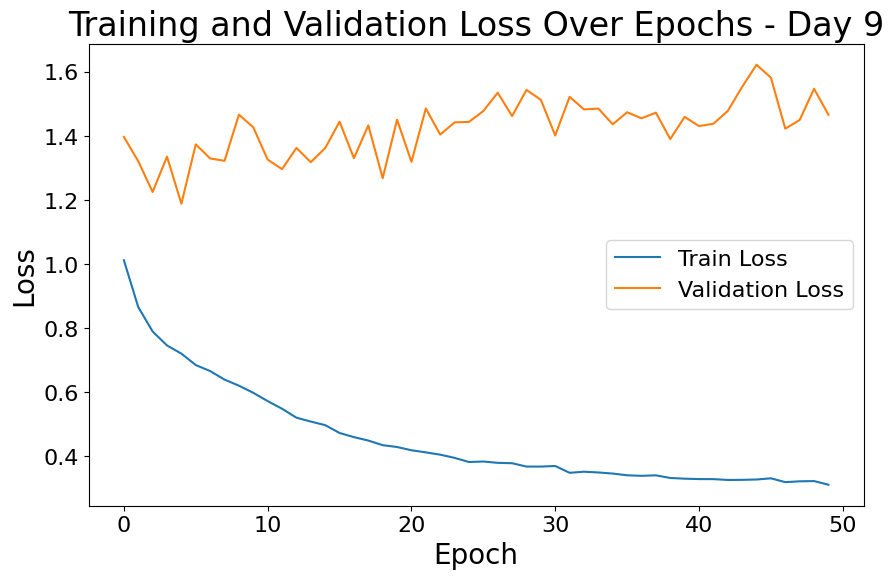

In [26]:
# Plotting the training and validation loss
mean_train_loss = np.mean(train_loss_list, axis=0)
mean_val_loss = np.mean(val_loss_list, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(range(50), mean_train_loss, label='Train Loss')
plt.plot(range(50), mean_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs - Day 9', fontsize=24)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
#plt.savefig("/content/drive/MyDrive/Master/data/plots/cnn_loss_day_9.png", dpi=400)



In [14]:
#
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Compute class weights from all training patches
class_counts = []
for x, y, _ in full_train_loader9:
    class_counts.extend(y.cpu().tolist())

labels, counts = np.unique(class_counts, return_counts=True)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(class_weights)

print("Class counts:", counts)
print("Class weights:", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
num_classes = 3
num_epochs = best_epoch

model = ResNet18HSI(num_classes=num_classes, num_bands=32).to(device)

criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.05
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Class counts: [1906  933 5155]
Class weights: [0.87909239 1.79587364 0.32503397]


/tmp/ipython-input-2602582140.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


### Training model on full training dataset

In [27]:
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0
    train_total = 0
    train_true = []
    train_pred = []

    for x, y, ids in full_train_loader9:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.cuda.amp.autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        train_loss_sum += loss.item() * x.size(0)
        train_total += y.size(0)

        preds = out.argmax(1)
        train_true.extend(y.cpu().tolist())
        train_pred.extend(preds.cpu().tolist())

    train_loss = train_loss_sum / train_total
    train_acc = accuracy_score(train_true, train_pred)
    train_f1 = f1_score(train_true, train_pred, average="macro")


    model.eval()
    val_loss_sum = 0.0
    val_total = 0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for x, y, _ in test_loader9:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss_sum += loss.item() * x.size(0)
            val_total += y.size(0)

            preds = out.argmax(1)
            val_true.extend(y.cpu().tolist())
            val_pred.extend(preds.cpu().tolist())

    test_loss = val_loss_sum / val_total


    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)



/tmp/ipython-input-2509223846.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2509223846.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2509223846.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2509223846.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2509223846.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-2509223846.

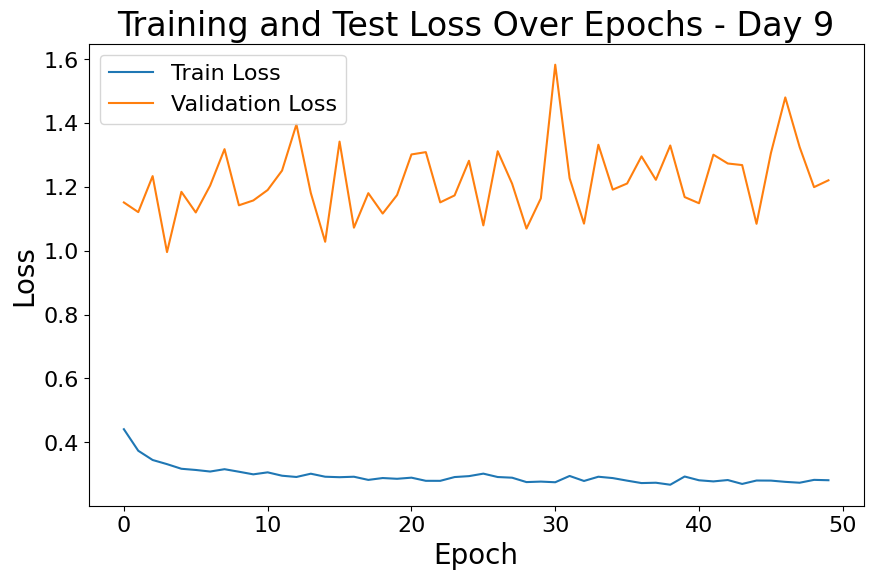

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_list, label='Train Loss')
plt.plot(range(num_epochs), test_loss_list, label='Validation Loss')
plt.title('Training and Test Loss Over Epochs - Day 9', fontsize=24)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
#plt.savefig("/content/drive/MyDrive/Master/data/plots/cnn_loss_day_9.png", dpi=400)



In [31]:
test_patch_acc, test_patch_f1_macro, test_patch_f1_weighted = \
    evaluate_patchwise(model, test_loader9, device)

print(f"[TEST patch-wise] Acc={test_patch_acc:.3f}, "
      f"F1-macro={test_patch_f1_macro:.3f}, F1-weighted={test_patch_f1_weighted:.3f}")

test_img_acc, test_img_f1_macro, (y_true_img, y_pred_img) = \
    evaluate_image_wise(model, test_loader9, device, print_report=False)

print(f"[TEST image-wise] Acc={test_img_acc:.3f}, F1-macro={test_img_f1_macro:.3f}")

[TEST patch-wise] Acc=0.706, F1-macro=0.643, F1-weighted=0.714
[TEST image-wise] Acc=0.900, F1-macro=0.863


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
def plot_confusion_matrices_per_day(y_true, y_pred, day=None, class_names=None):
    """
    Plots one confusion matrix per unique day.

    y_true:  (N,) list/array of true labels (image-wise)
    y_pred:  (N,) list/array of predicted labels (image-wise)
    day_ids: (N,) list/array indicating day for each image
    class_names: optional list of names for classes (e.g. ["Control","Drought","Mites"])
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    for text in disp.ax_.get_children():
      if isinstance(text, Text):
        if re.fullmatch(r"\d+", text.get_text()):  # match integers
            text.set_fontsize(14)
    disp.ax_.tick_params(axis='y', labelsize=14)
    disp.ax_.tick_params(axis='x', labelsize=14, rotation=45)
    # Change axis labels
    disp.ax_.set_xlabel("Predicted label", fontsize=18)
    disp.ax_.set_ylabel("True label", fontsize=18)
    plt.title(f"ResNet18 Confusion Matrix – Day {day}", fontsize=20)
    plt.savefig(f"/content/drive/MyDrive/Master/data/plots/confusion_matrix_day_cnn_{day}.png", dpi=400)
    plt.tight_layout()
    plt.show()


<Figure size 500x400 with 0 Axes>

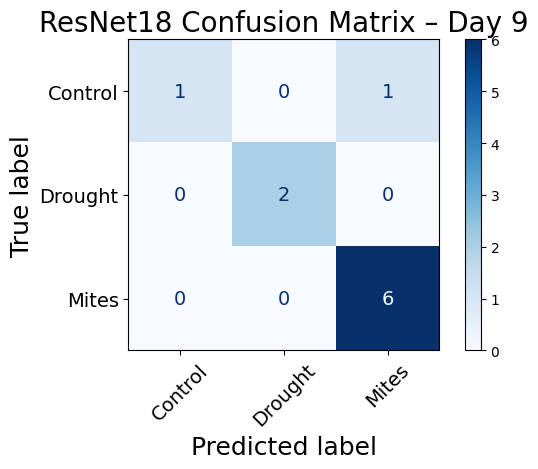

In [33]:
class_names = ["Control", "Drought", "Mites"]

plot_confusion_matrices_per_day(y_true_img, y_pred_img, 9, class_names)
